# Frozen-Lake强化学习代码实现(Q-Learning)

### 导入必要的包

In [27]:
%matplotlib inline

import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import matplotlib.pyplot as plt
import itertools
import matplotlib.style
import csv
import numpy as np
import sys
import os

from collections import defaultdict
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

matplotlib.style.use('ggplot')

### 调整参数和配置

In [28]:
# 各个时期的训练参数
train_para = [
    {'epsilon':0.8,  'num_episodes':1000, 'discount_factor':0.99, 'alpha':0.5, 'success_num':0 ,'Q':None},
    {'epsilon':0.5,  'num_episodes':1000, 'discount_factor':0.99, 'alpha':0.5, 'success_num':0 ,'Q':None},
    {'epsilon':0.2,  'num_episodes':1000, 'discount_factor':0.99, 'alpha':0.5, 'success_num':0 ,'Q':None},
    {'epsilon':0.01, 'num_episodes':1000, 'discount_factor':0.99, 'alpha':0.5, 'success_num':0 ,'Q':None}
]

# 地图大小
MAP_SIZE = 8

# 是否使用随机地图
RANDOM_MAP = True

# 是否保存正确率较低的地图到 自定义地图 的 位置
SAVE_ERROR_MAP = True

# 自定义地图 的 位置
CUSTOM_MAP_ROUTE = "./errormap/output.csv"

# 每进行几轮记录一次视频
INTERVAL=100

# 保存视频的位置
VIDEO_FOLDER='./save_videos1'


goal_state = MAP_SIZE**2 - 1


### 生成一个地图

In [29]:
def generate_map():
    custom_map = []
    if RANDOM_MAP:
        custom_map = generate_random_map(size=MAP_SIZE)
    else:
        with open('./errormap/output.csv', 'r') as f:
            reader = csv.reader(f)
            for row in reader:
                custom_map.append(row)
    return custom_map

### 生成一个环境

In [30]:
def generate_env():
    custom_map = generate_map()
    env = gym.make('FrozenLake-v1',desc=custom_map,render_mode="rgb_array",is_slippery=False)
    trigger = lambda t: t % INTERVAL == 0
    env = RecordVideo(env, video_folder=VIDEO_FOLDER, episode_trigger=trigger, disable_logger=True)

    return env,custom_map

### $\epsilon$ - 贪心策略

$$
\pi(a|s)=
\begin{cases}
    1 - \epsilon + \frac{\epsilon}{|A|} & \text{if} \space a = argmax_{a'}Q(S,a') \\
    \frac{\epsilon}{|A|} & \text{else}
\end{cases}
$$

In [31]:
def make_epsilon_greedy_policy(Q, epsilon ,nA):

    def policy_fn(observation):
        A = np.ones(nA,dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

### 计算两点间的曼哈顿距离

$$
\text{Distance} = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}
$$

In [32]:
def calculate_distance(x_1,y_1,x_2,y_2):
    # distance = ((x_1-x_2)**2 + (y_1-y_2)**2)**0.5
    distance = abs(x_1 - x_2) + abs(y_1 - y_2)
    return distance

### **高斯奖励函数（Gaussian Reward Function）**

#### **数学公式**
$$
r(s, a, s') = \beta \cdot e^{-\frac{d(s', s_g)^2}{2\sigma^2}}
$$

#### **参数说明**
| 符号         | 含义                          | 常用值示例  |
|--------------|-------------------------------|------------|
| $\beta$      | 奖励峰值（最大值）            | 10         |
| $\sigma$     | 控制奖励衰减速度的标准差      | 2          |
| $d(s', s_g)$ | 新状态 $s'$ 到目标状态 $s_g$ 的距离 | 欧氏/曼哈顿距离 |

In [33]:
def signed_reward(distance, beta=10, sigma=2, threshold=5):
    """
    距离小于threshold时为正奖励，大于时为负奖励
    """
    if distance <= threshold:
        return beta * np.exp(-(distance**2)/(2*sigma**2))#高斯奖励
    else:
        return -1 * (distance - threshold)  # 线性惩罚


### 奖励函数设计
#### 正奖励
- 当agent的state恰好等于目标点的state时
- 当agent距离目标点距离减小
#### 负奖励
- 当agent掉入洞中或超时
- 当agent不动时
- 当agent距离目标点距离增大

In [34]:
def getReward(state, next_state,state_number,random_state, success_num, terminated, truncated):

    if random_state:
        if state_number[next_state] < 2 and not terminated and not truncated:
            reward = 7
        else:
            reward = -5
    else:

        reward = 0
    #terminated=True：智能体找到出口（成功）或撞墙（失败）。
    #truncated=True：智能体超过 1000 步仍未找到出口（强制终止）。
        # 计算state距离终点的距离->方便计算欧式距离
        state_x = state // MAP_SIZE
        state_y = state % MAP_SIZE

        state_dist = calculate_distance(state_x, state_y, MAP_SIZE - 1, MAP_SIZE - 1)

        # 计算next_state距离终点的距离
        next_state_x = next_state // MAP_SIZE
        next_state_y = next_state % MAP_SIZE
    #Python 中的整数除法（向下取整），例如 7 // 3 = 2
        next_state_dist = calculate_distance(next_state_x, next_state_y, MAP_SIZE - 1, MAP_SIZE - 1)
        go_dist=next_state_dist- state_dist
        # 恰好达到目标
        if next_state == goal_state:
            # reward = 1.6
            success_num = success_num + 1
            reward = signed_reward(go_dist, beta=10, sigma=2, threshold=5)

        # 调入洞中或超时
        elif terminated or truncated:
            reward = -10#reward过小时角色容易掉洞

        # 原地不动
        elif state == next_state:
            # reward = -0.9
            reward = signed_reward(next_state_dist, beta=10, sigma=2, threshold=5)

        # 远离目标点
        elif next_state_dist > state_dist:
            # reward = -0.7
            reward = signed_reward(next_state_dist, beta=10, sigma=2, threshold=5)

        # 靠近目标点
        elif next_state_dist < state_dist:
            # reward = state_dist - next_state_dist
            reward = signed_reward(next_state_dist, beta=10, sigma=2, threshold=5)

    return reward, success_num

### Q-Learning 算法

$$
Q^{new}(S_t,A_t) = (1 - \alpha) \cdot Q(S_t,A_t) + \alpha \cdot \big(R_{t+1} + \gamma \cdot max_a Q(S_{t+1},a) \big)
$$

In [35]:
def q_learning(Q,state,action,next_state,reward,discount_factor,alpha):
    best_next_action = np.argmax(Q[next_state])
    td_target = reward + discount_factor * best_next_action
    td_delta = td_target - Q[state][action]
    Q[state][action] += alpha * td_delta
    return Q

### 进度条

In [36]:
def simple_progress_bar(total, progress):  
    """  
    显示一个简单的进度条  
  
    :param total: 进度条的总长度（或总任务量）  
    :param progress: 当前进度（已完成的任务量）  
    """  
    bar_length = 50  # 进度条的长度，这里设置为50个字符  
    filled_length = int(round(bar_length * progress / float(total)))  # 计算已完成的进度条长度  
    # 注意这里使用了float(total)确保除法结果是浮点数，然后通过round和int转换得到整数长度  
    percents = round(100.0 * progress / float(total), 1)  # 计算并格式化当前进度的百分比，保留一位小数  
    bar = '=' * filled_length + '-' * (bar_length - filled_length)  # 根据已完成和未完成的长度生成进度条字符串  
    # 使用'='表示已完成的进度，'-'表示未完成的进度  
    sys.stdout.write(f'\r进度：[{bar}] {percents}%')  # 将进度条信息写回标准输出，\r使光标回到行首  
    # 这样新的进度信息就会覆盖旧的进度信息，实现进度条的更新效果  
    sys.stdout.flush()  # 刷新标准输出缓冲区，确保进度条信息立即显示 

### 训练过程

In [37]:
def train(env, num_episodes,final,discount_factor=0.99, alpha=0.3, epsilon=0.2, Q=None):
    success_num=0

    # Q-Table 不存在则初始化 Q-Table
    if Q==None:
        Q = defaultdict(lambda: np.ones(env.action_space.n))
        
    policy = make_epsilon_greedy_policy(Q,epsilon,env.action_space.n)

    # 记录每个回合走了多少步
    plot_episode_length = np.zeros(num_episodes)
    # 记录每个回合的总奖励
    plot_episode_rewards = np.zeros(num_episodes)

    # 执行 num_episodes 个回合
    for i_episodes in range(num_episodes):
        
        # 显示进度条
        simple_progress_bar(num_episodes,i_episodes)
        
        # 创建一个记录每个state走过的次数
        state_number = {x : 0 for x in range(MAP_SIZE*MAP_SIZE)}

        # 每个回合重置环境
        state,_ = env.reset()

        for t in itertools.count():
            random_state = False
            if not final:
                state_number[state] += 1

            if state_number[state] <= 2:
                # 依据epsilon-贪心算法获得state处每个动作的概率
                action_probs = policy(state)
                # 依据概率随机选择一个动作
                action = np.random.choice(np.arange(len(action_probs)),p=action_probs)
                
                random_state = False
                
            else:
                action = env.action_space.sample()
                random_state = True

            next_state,reward,terminated,truncated,info = env.step(action)

            reward,success_num = getReward(state,next_state,state_number,random_state,success_num,terminated,truncated)
            
            # 更新每个回合的步数和奖励
            plot_episode_length[i_episodes] = t
            plot_episode_rewards[i_episodes] += reward

            # 将所得到的数据更新 Q-Table
            Q = q_learning(Q,state,action,next_state,reward,discount_factor,alpha)

            # 遇到异常情况则退出 进入下一回合
            if terminated or truncated:
                break

            state = next_state
    
    return Q,plot_episode_rewards,plot_episode_length,success_num

### 使用Matplotlib绘图

In [38]:
def plotting(data,xlable,ylabel):
    plt.figure(figsize=(10,5))
    plt.xlabel(xlable)
    plt.ylabel(ylabel)
    plt.plot(data)
    plt.show()

### 调用函数进行训练


1/4
进度：[--------------------------------------------------] 0.0%

/home/dxj/.conda/envs/gymlab/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/dxj/Documents/workspace/frozen-lake/save_videos1 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


进度：[==================================================] 99.9%
2/4
进度：[==================================================] 99.9%
3/4
进度：[==================================================] 99.9%
4/4
进度：[==================================================] 99.9%
Accurate Rate:0.765


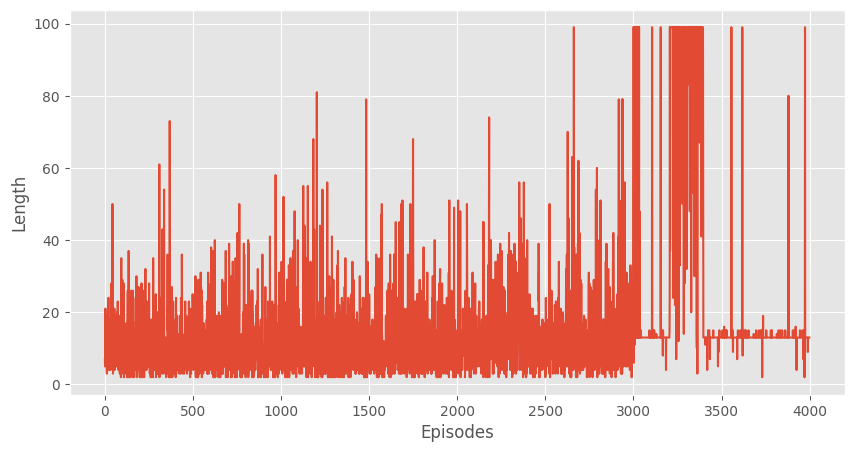

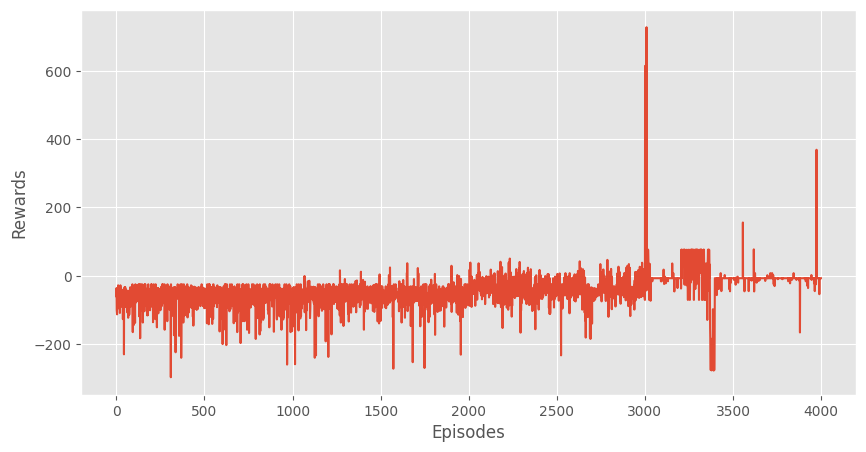

In [39]:
if __name__ == "__main__":

    env,custom_map = generate_env()

    Q = None

    train_result = [
        {'Q':None , 'plot_episode_rewards': None, 'plot_episode_length': None,'success_num': 0},
        {'Q':None , 'plot_episode_rewards': None, 'plot_episode_length': None,'success_num': 0},
        {'Q':None , 'plot_episode_rewards': None, 'plot_episode_length': None,'success_num': 0},
        {'Q':None , 'plot_episode_rewards': None, 'plot_episode_length': None,'success_num': 0}
    ]

    for i in range(len(train_para)) :
        final = False
        if i > 0:
            train_result[i]['Q'] = train_result[i-1]['Q']
        
        if i == len(train_para)-1:
            final = True

        train_result[i]['plot_episode_rewards'] = np.zeros(train_para[i]['num_episodes'])
        train_result[i]['plot_episode_length'] = np.zeros(train_para[i]['num_episodes'])

        sys.stdout.flush()
        print("\r\n{}/{}".format(i+1,len(train_para)))
        train_result[i]['Q'], train_result[i]['plot_episode_rewards'], train_result[i]['plot_episode_length'], train_result[i]['success_num'] = train(
            env,
            num_episodes=train_para[i]['num_episodes'],
            final=final,
            discount_factor=train_para[i]['discount_factor'],
            alpha=train_para[i]['alpha'],
            epsilon=train_para[i]['epsilon'],
            Q=train_result[i]['Q']
        )

    rewards = []
    length = []

    for train in train_result:
        rewards = np.concatenate((rewards,train['plot_episode_rewards']))
        length = np.concatenate((length,train['plot_episode_length']))

    accurate_rate = train_result[-1]['success_num'] / train_para[-1]['num_episodes']

    if accurate_rate < 0.7:
        os.makedirs(os.path.dirname(CUSTOM_MAP_ROUTE), exist_ok=True)
        with open(CUSTOM_MAP_ROUTE, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerows(custom_map)

    print("\r\nAccurate Rate:{}".format(accurate_rate))

    plotting(length,"Episodes","Length")
    plotting(rewards,"Episodes","Rewards")

    env.close()